# Вебинар 6. Консультация по курсовому проекту.

### Задание для курсового проекта

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Сдать проект нужно в течение 7 дней после окончания последнего вебинара.
2. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на ноутбук в github или public kaggle notebook.
3. Необходимо получить R2 > 0.6 на Private Leaderboard.
4. Укажите свой ник на kaggle 


Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.
____________
Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. По возможности добавлять графики, описывающие данные (около 3-5)
4. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
5. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
6. Весь проект должен быть в одном скрипте (файл ipynb).
7. При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна.
8. Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров. 

**План занятия**
* [Загрузка данных](#load)
* [1. EDA](#eda)
* [2. Обработка выбросов](#outlier)
* [3. Обработка пропусков](#nan)
* [4. Построение новых признаков](#feature)
* [5. Отбор признаков](#feature_selection)
* [6. Разбиение на train и test](#split)
* [7. Построение модели](#modeling)
* [8. Прогнозирование на тестовом датасете](#prediction)

**Подключение библиотек и скриптов**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv
/kaggle/input/real-estate-price-prediction-moscow/train.csv
/kaggle/input/real-estate-price-prediction-moscow/test.csv


In [2]:
import pandas as pd
import numpy as np
import sklearn as skl
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from datetime import datetime
import xgboost as xgb
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
plt.rcParams.update({'font.size': 14})

In [5]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [6]:
TRAIN_DATASET_PATH = '../input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '../input/real-estate-price-prediction-moscow/test.csv'

### Загрузка данных <a class='anchor' id='load'>

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [8]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [9]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [10]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [11]:
train_df.shape[1] - 1 == test_df.shape[1]

True

### Приведение типов

In [12]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [13]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

## 1. EDA  <a class='anchor' id='eda'>
Делаем EDA для:
- Исправления выбросов
- Заполнения NaN
- Идей для генерации новых фич

**Целевая переменная**

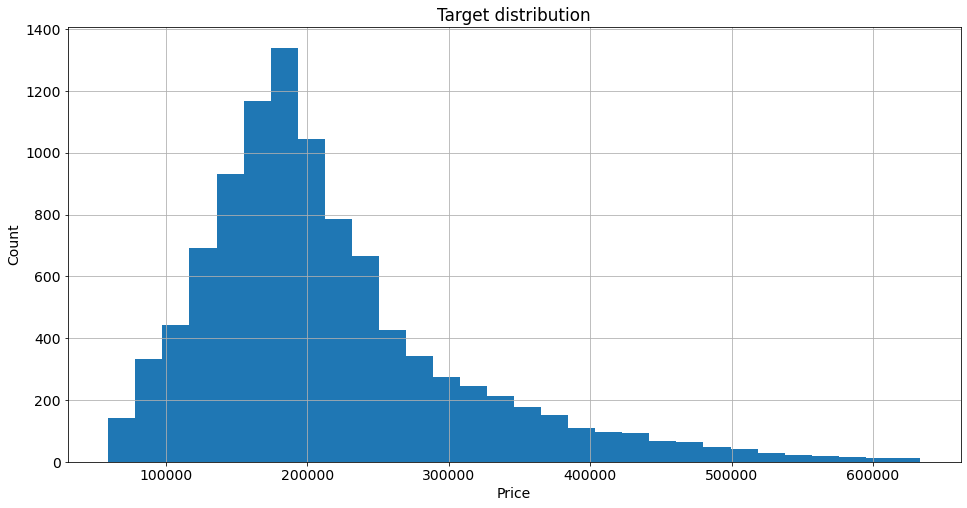

In [14]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

**Количественные переменные**

In [15]:
# train_df.describe()

**Номинативные переменные**

In [16]:
# train_df.select_dtypes(include='object').columns.tolist()

In [17]:
# train_df['DistrictId'].value_counts()

In [18]:
# train_df['Ecology_2'].value_counts()

In [19]:
# train_df['Ecology_3'].value_counts()

In [20]:
# train_df['Shops_2'].value_counts()

### 2. Обработка выбросов  <a class='anchor' id='outlier'>
Что можно делать с ними?
1. Выкинуть эти данные (только на трейне, на тесте ничего не выкидываем)
2. Заменять выбросы разными методами (медианы, средние значения, np.clip и т.д.)
3. Делать/не делать дополнительную фичу
4. Ничего не делать

**Rooms**

In [21]:
# train_df['Rooms'].value_counts()

In [22]:
# train_df['Rooms_outlier'] = 0
# train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
# train_df.head()

In [23]:
# train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
# train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [24]:
# train_df['Rooms'].value_counts()

**KitchenSquare** 

In [25]:
# train_df['KitchenSquare'].value_counts()

In [26]:
# train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

In [27]:
# condition = (train_df['KitchenSquare'].isna()) \
#              | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
# train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

# train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [28]:
# train_df['KitchenSquare'].value_counts()

**HouseFloor, Floor**

In [29]:
# train_df['HouseFloor'].sort_values().unique()

In [30]:
# train_df['Floor'].sort_values().unique()

In [31]:
# (train_df['Floor'] > train_df['HouseFloor']).sum()

In [32]:
# train_df['HouseFloor_outlier'] = 0
# train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
# train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [33]:
# train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [34]:
# floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
# floor_outliers

In [35]:
# train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
#                                                 .apply(lambda x: random.randint(1, x))

In [36]:
# (train_df['Floor'] > train_df['HouseFloor']).sum()

**HouseYear**

In [37]:
# train_df['HouseYear'].sort_values(ascending=False)

In [38]:
# train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

### 3. Обработка пропусков  <a class='anchor' id='nan'>

In [39]:
# train_df.isna().sum()

In [40]:
# train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

**LifeSquare**

In [41]:
# train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

# condition = (train_df['LifeSquare'].isna()) \
#              & (~train_df['Square'].isna()) \
#              & (~train_df['KitchenSquare'].isna())
        
# train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
#                                             - train_df.loc[condition, 'KitchenSquare'] - 3

**Healthcare_1**

In [42]:
# train_df.drop('Healthcare_1', axis=1, inplace=True)

In [43]:
# class DataPreprocessing:
#     """Подготовка исходных данных"""

#     def __init__(self):
#         """Параметры класса"""
#         self.medians = None
#         self.kitchen_square_quantile = None
        
#     def fit(self, X):
#         """Сохранение статистик"""       
#         # Расчет медиан
#         self.medians = X.median()
#         self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
#     def transform(self, X):
#         """Трансформация данных"""

#         # Rooms
#         X['Rooms_outlier'] = 0
#         X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
#         X.loc[X['Rooms'] == 0, 'Rooms'] = 1
#         X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
#         # KitchenSquare
#         condition = (X['KitchenSquare'].isna()) \
#                     | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
#         X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

#         X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
#         # HouseFloor, Floor
#         X['HouseFloor_outlier'] = 0
#         X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
#         X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
#         X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
#         floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
#         X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
#                                             .apply(lambda x: random.randint(1, x))
        
#         # HouseYear
#         current_year = datetime.now().year
        
#         X['HouseYear_outlier'] = 0
#         X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
#         X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
#         # Healthcare_1
#         if 'Healthcare_1' in X.columns:
#             X.drop('Healthcare_1', axis=1, inplace=True)
            
#         # LifeSquare
#         X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
#         condition = (X['LifeSquare'].isna()) & \
#                       (~X['Square'].isna()) & \
#                       (~X['KitchenSquare'].isna())
        
#         X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
#         X.fillna(self.medians, inplace=True)
        
#         return X

### 4. Построение новых признаков  <a class='anchor' id='feature'>

**Dummies**

In [44]:
# binary_to_numbers = {'A': 0, 'B': 1}

# train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
# train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
# train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

**DistrictSize, IsDistrictLarge**

In [45]:
# district_size = train_df['DistrictId'].value_counts().reset_index()\
#                     .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

# district_size.head()

In [46]:
# train_df = train_df.merge(district_size, on='DistrictId', how='left')
# train_df.head()

In [47]:
# (train_df['DistrictSize'] > 100).value_counts()

In [48]:
# train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

**MedPriceByDistrict**

In [49]:
# med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
#                             .rename(columns={'Price':'MedPriceByDistrict'})

# med_price_by_district.head()

In [50]:
# med_price_by_district.shape

In [51]:
# train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
# train_df.head()

**MedPriceByFloorYear**

In [52]:
# def floor_to_cat(X):

#     X['floor_cat'] = 0

#     X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
#     X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
#     X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
#     X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
#     X.loc[X['Floor'] > 15, 'floor_cat'] = 5

#     return X


# def floor_to_cat_pandas(X):
#     bins = [X['Floor'].min(), 3, 5, 9, 15, X['Floor'].max()]
#     X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
#     X['floor_cat'].fillna(-1, inplace=True)
#     return X


# def year_to_cat(X):

#     X['year_cat'] = 0

#     X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
#     X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
#     X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
#     X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
#     X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
#     X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

#     return X


# def year_to_cat_pandas(X):
#     bins = [X['HouseYear'].min(), 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
#     X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
#     X['year_cat'].fillna(-1, inplace=True)
#     return X

In [53]:
# bins = [train_df['Floor'].min(), 3, 5, 9, 15, train_df['Floor'].max()]
# pd.cut(train_df['Floor'], bins=bins, labels=False)

In [54]:
# bins = [train_df['Floor'].min(), 3, 5, 9, 15, train_df['Floor'].max()]
# pd.cut(train_df['Floor'], bins=bins)

In [55]:
# train_df = year_to_cat(train_df)
# train_df = floor_to_cat(train_df)
# train_df.head()

In [56]:
# med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
#                                             rename(columns={'Price':'MedPriceByFloorYear'})
# med_price_by_floor_year.head()

In [57]:
# train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
# train_df.head()

In [58]:
# class FeatureGenetator():
#     """Генерация новых фич"""
    
#     def __init__(self):
#         self.DistrictId_counts = None
#         self.binary_to_numbers = None
#         self.med_price_by_district = None
#         self.med_price_by_floor_year = None
#         self.house_year_max = None
#         self.floor_max = None
#         self.house_year_min = None
#         self.floor_min = None
#         self.district_size = None
        
#     def fit(self, X, y=None):
        
#         X = X.copy()
        
#         # Binary features
#         self.binary_to_numbers = {'A': 0, 'B': 1}
        
#         # DistrictID
#         self.district_size = X['DistrictId'].value_counts().reset_index() \
#                                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
#         # Target encoding
#         ## District, Rooms
#         df = X.copy()
        
#         if y is not None:
#             df['Price'] = y.values
            
#             self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
#                                             .rename(columns={'Price':'MedPriceByDistrict'})
            
#             self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
#         ## floor, year
#         if y is not None:
#             self.floor_max = df['Floor'].max()
#             self.floor_min = df['Floor'].min()
#             self.house_year_max = df['HouseYear'].max()
#             self.house_year_min = df['HouseYear'].min()
#             df['Price'] = y.values
#             df = self.floor_to_cat(df)
#             df = self.year_to_cat(df)
#             self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
#                                             rename(columns={'Price':'MedPriceByFloorYear'})
#             self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
#     def transform(self, X):
        
#         # Binary features
#         X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
#         X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
#         X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
#         # DistrictId, IsDistrictLarge
#         X = X.merge(self.district_size, on='DistrictId', how='left')
        
#         X['new_district'] = 0
#         X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
#         X['DistrictSize'].fillna(5, inplace=True)
        
#         X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
#         # More categorical features
#         X = self.floor_to_cat(X)  # + столбец floor_cat
#         X = self.year_to_cat(X)   # + столбец year_cat
        
#         # Target encoding
#         if self.med_price_by_district is not None:
#             X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
#             X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
#         if self.med_price_by_floor_year is not None:
#             X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
#             X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
#         return X
    
#     def floor_to_cat(self, X):
#         bins = [self.floor_min, 3, 5, 9, 15, self.floor_max]
#         X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

#         X['floor_cat'].fillna(-1, inplace=True)
#         return X
     
#     def year_to_cat(self, X):
#         bins = [self.house_year_min, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
#         X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

#         X['year_cat'].fillna(-1, inplace=True)
#         return X

### 5. Отбор признаков  <a class='anchor' id='feature_selection'>

In [59]:
# train_df.columns.tolist()

In [60]:
# feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
#                  'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
#                  'Helthcare_2', 'Shops_1', 'Shops_2']

# new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
#                      'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear']

# target_name = 'Price'

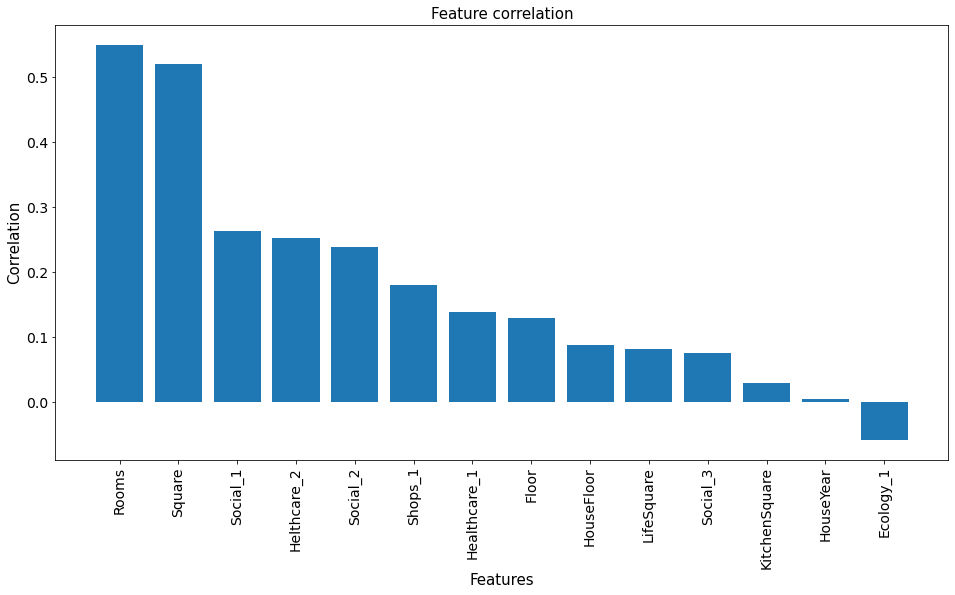

In [61]:
correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize = (16, 8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()

In [62]:
class DataPreprocessor:
    def __init__(self):
        self.medians = None
        self.kitchen_square_max_value = None
        self.kitchen_square_min_value = None
        self.life_square_min_value = None
        self.max_floor = None
        self.districts_healthcare = None


        
    def fit(self, df):
        # Medians and quantiles
        self.medians = df.median() # medians
        self.kitchen_square_max_value = np.quantile(df['KitchenSquare'], q=0.999) 
        self.kitchen_square_min_value = np.quantile(df['KitchenSquare'], q=0.001) 
        self.life_square_min_value = np.quantile(df['LifeSquare'], q=0.03) 
        self.max_floor = df['Floor'].max()
        
        
        # Compute mean Helthcare_1 value in each district
        self.districts_healthcare = df.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()


    def transform(self, df):
        # Life Square fillna
        df['LifeSquare'].fillna(((df['Square'] - df['KitchenSquare']) - df['Square']*0.2), inplace=True)


        # Rooms
        # Fillna with medians         
        df['Rooms'].fillna(self.medians.Rooms, inplace=True) 
        
        # Compute median room square and fill outliers with LifeSquare/Room_square 
        condition_rooms = (df['Rooms'] > 6) | (df['Rooms'] == 0)   
        room_sq = np.round((self.medians.LifeSquare / self.medians.Rooms, 1))[0]
        df.loc[condition_rooms , 'Rooms'] = df.loc[condition_rooms, 'LifeSquare'] / room_sq

        # Square
        # If LifeSquare > Square: exchange values
        df['Square'], df['LifeSquare'] = np.where(df['Square'] < df['LifeSquare'],(df['LifeSquare'],df['Square']), (df['Square'],df['LifeSquare']))


        # LifeSquare
        # Fill outliers with (Square - KithcenSquare)
        ls_condition = (df['LifeSquare'] < self.life_square_min_value)
        df.loc[ls_condition, 'LifeSquare'] = df.loc[ls_condition, ['Square']] - df.loc[ls_condition, ['KitchenSquare']]
  
        
        # KitchenSquare
        # Fill outliers with (Square - LifeSquare - 10% of Square)
        condition_kitchen_square = (df['KitchenSquare'] > self.kitchen_square_max_value) | (df['KitchenSquare'] < self.kitchen_square_min_value)
        df.loc[condition_kitchen_square, 'KitchenSquare'] = df.loc[condition_kitchen_square, 'Square'] - df.loc[condition_kitchen_square, 'LifeSquare'] \
        - (df.loc[condition_kitchen_square, 'Square'] * 0.1)


        # Ecology and Shops
        # Switch to binary
        df.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)
        
        
        # HouseFloor
        # If HouseFloor < Floor: exchange values
        house_floor_condition = df['HouseFloor'] < df['Floor']
        df.loc[house_floor_condition, 'HouseFloor'] = df.loc[house_floor_condition, 'Floor']

        
        # HouseYear
        # If HouseYear > current year set median value
        current_year = datetime.now().year
        condition_year = (df['HouseYear'] > current_year)
        df.loc[condition_year, 'HouseYear'] = self.medians.HouseYear
        
        
        # Healthcare
        # Fillna with dictrict healthcare value. (If district has no healthcare value fill with medians)      
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = df['DistrictId'].map(self.districts_healthcare)
        df['Healthcare_1'].fillna(self.medians.Healthcare_1, inplace=True)       
        # Clip on upper quantille
        q_max = np.quantile(df['Healthcare_1'], q=0.9)
        df['Healthcare_1'].clip(upper=q_max, axis=0, inplace=True)
        
        
        # Drop Id
        df.drop(['Id'], axis=1, inplace=True)

        
        # Fillna just in case
        df.fillna(self.medians, inplace=True)
        return df




In [63]:
class FeatureGenerator:
    def __init__(self):
        self.districts_median_year = None
        self.districts_density = None
        self.district_price_per_square = None
        self.min_sq = None
        self.max_sq = None

        
    def fit(self, df):   
        self.min_sq = np.quantile(df['Square'], q=0.005)
        self.max_sq = np.quantile(df['Square'], q=0.995)
        
        self.districts_median_year = df.groupby(['DistrictId'])['HouseYear'].agg('median').to_dict()  # median house year in each district
        self.districts_density = df.groupby(['DistrictId'])['Square'].agg('median').to_dict()  # median square in each district
        self.district_price_per_square = df.groupby(['DistrictId'])['Price'].agg('median') \
        / df.groupby(['DistrictId'])['Square'].agg('median')  # median price for square meter in each district
        
    
    def new_features(self, df):
        # How old is the district      
        df['DistrictYear'] = df['DistrictId'].map(self.districts_median_year)
        
        self.median_district_year = df['DistrictYear'].median()
        df['DistrictYear'].fillna(self.median_district_year, inplace=True)


        # Median square of flat in each district
        df['DistrictDensity'] = df['DistrictId'].map(self.districts_density)
        
        self.median_district_density = df['DistrictDensity'].median()
        df['DistrictDensity'].fillna(self.median_district_density, inplace=True)


        # Median price for square meter in each district
        self.district_price_per_square.to_dict()
        df['DistrictPrice'] = df['DistrictId'].map(self.district_price_per_square)
        
        self.median_district_price_per_square = df['DistrictPrice'].median()
        df['DistrictPrice'].fillna(self.median_district_price_per_square, inplace=True)


        # Floor category
        floor_bins = [0, 4, 7, 12, df['Floor'].max()]
        df['Floor_cat'] = pd.cut(df['Floor'], bins=floor_bins, labels=False)
        df['Floor_cat'].fillna(-1, inplace=True) 

        
        # Scale and merge Social
        scaler = RobustScaler()
        pca = PCA(n_components=1, random_state=42)
        social_scaled = pd.DataFrame(scaler.fit_transform(df[['Social_1', 'Social_2', 'Social_3']]))
        df['Social'] = pca.fit_transform(social_scaled)
        
        
        df.drop(['Ecology_2', 'Ecology_3', 'Shops_2', 'Helthcare_2', 'Floor',], axis=1, inplace=True)
        
        return df
    
    
    def drop_outliers(self, df):
        df = df.loc[(df['Square'] > self.min_sq) & (df['Square'] < self.max_sq)]
        
        
        
        return df


In [64]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [65]:
# # test_df.DistrictId.isnull()
# districts_median_year = train_df.groupby(['DistrictId'])['HouseYear'].agg('median').to_dict() 
# test_df['DistrictId'] = test_df['DistrictId'].apply(str)
# # districts_median_year['44']
# test_df['DistrictYear'] = test_df['DistrictId'].map(districts_median_year)
# median_district_year = test_df['DistrictYear'].median()
# test_df['DistrictYear'].fillna(median_district_year, inplace=True)

# # test_df['DistrictId']

# districts_density = train_df.groupby(['DistrictId'])['Square'].agg('median').to_dict()  # median square in each district
# # Median square of flat in each district
# test_df['DistrictDensity'] = test_df['DistrictId'].map(districts_density)

# median_district_density = test_df['DistrictDensity'].median()
# test_df['DistrictDensity'].fillna(median_district_density, inplace=True)
# # test_df['DistrictDensity']

# district_price_per_square = train_df.groupby(['DistrictId'])['Price'].agg('median') \
# / train_df.groupby(['DistrictId'])['Square'].agg('median')  # median price for square meter in each district
# # Median price for square meter in each district
# district_price_per_square.to_dict()
# test_df['DistrictPrice'] = test_df['DistrictId'].map(district_price_per_square)

# median_district_price_per_square = test_df['DistrictPrice'].median()
# test_df['DistrictPrice'].fillna(median_district_price_per_square, inplace=True)
# # test_df['DistrictPrice']
# test_df.info()

In [66]:
# Data preprocessing
preprocessor = DataPreprocessor()
preprocessor.fit(train_df)
train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)
# Feature generation
features_gen = FeatureGenerator()
features_gen.fit(train_df)
train_df = features_gen.new_features(train_df)
train_df = features_gen.drop_outliers(train_df)
test_df = features_gen.new_features(test_df)
# train_df = features_gen.drop_outliers(train_df)

In [67]:
# test_df.DistrictId.isnull()
districts_median_year = train_df.groupby(['DistrictId'])['HouseYear'].agg('median').to_dict() 
test_df['DistrictId'] = test_df['DistrictId'].apply(str)
# districts_median_year['44']
test_df['DistrictYear'] = test_df['DistrictId'].map(districts_median_year)
median_district_year = test_df['DistrictYear'].median()
test_df['DistrictYear'].fillna(median_district_year, inplace=True)

# test_df['DistrictId']

districts_density = train_df.groupby(['DistrictId'])['Square'].agg('median').to_dict()  # median square in each district
# Median square of flat in each district
test_df['DistrictDensity'] = test_df['DistrictId'].map(districts_density)

median_district_density = test_df['DistrictDensity'].median()
test_df['DistrictDensity'].fillna(median_district_density, inplace=True)
# test_df['DistrictDensity']

district_price_per_square = train_df.groupby(['DistrictId'])['Price'].agg('median') \
/ train_df.groupby(['DistrictId'])['Square'].agg('median')  # median price for square meter in each district
# Median price for square meter in each district
district_price_per_square.to_dict()
test_df['DistrictPrice'] = test_df['DistrictId'].map(district_price_per_square)

median_district_price_per_square = test_df['DistrictPrice'].median()
test_df['DistrictPrice'].fillna(median_district_price_per_square, inplace=True)
# test_df['DistrictPrice']
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DistrictId       5000 non-null   object 
 1   Rooms            5000 non-null   float64
 2   Square           5000 non-null   float64
 3   LifeSquare       5000 non-null   float64
 4   KitchenSquare    5000 non-null   float64
 5   HouseFloor       5000 non-null   float64
 6   HouseYear        5000 non-null   float64
 7   Ecology_1        5000 non-null   float64
 8   Social_1         5000 non-null   int64  
 9   Social_2         5000 non-null   int64  
 10  Social_3         5000 non-null   int64  
 11  Healthcare_1     5000 non-null   float64
 12  Shops_1          5000 non-null   int64  
 13  DistrictYear     5000 non-null   float64
 14  DistrictDensity  5000 non-null   float64
 15  DistrictPrice    5000 non-null   float64
 16  Floor_cat        5000 non-null   int64  
 17  Social        

### 6. Разбиение на train и test  <a class='anchor' id='split'>

In [68]:
# train_df = pd.read_csv(TRAIN_DATASET_PATH)
# test_df = pd.read_csv(TEST_DATASET_PATH)

# X = train_df.drop(columns=target_name)
# y = train_df[target_name]

In [69]:
y = pd.DataFrame(data=train_df['Price'])
train_df.drop('Price', axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.15, random_state=100)

In [70]:
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [71]:
# preprocessor = DataPreprocessing()
# preprocessor.fit(X_train)

# X_train = preprocessor.transform(X_train)
# X_valid = preprocessor.transform(X_valid)
# test_df = preprocessor.transform(test_df)

# X_train.shape, X_valid.shape, test_df.shape

In [72]:
# features_gen = FeatureGenetator()
# features_gen.fit(X_train, y_train)

# X_train = features_gen.transform(X_train)
# X_valid = features_gen.transform(X_valid)
# test_df = features_gen.transform(test_df)

# X_train.shape, X_valid.shape, test_df.shape

In [73]:
# X_train = X_train[feature_names + new_feature_names]
# X_valid = X_valid[feature_names + new_feature_names]
# test_df = test_df[feature_names + new_feature_names]

In [74]:
# X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

### 7. Построение модели  <a class='anchor' id='modeling'>

**Обучение**

In [75]:
# rf_model = RandomForestRegressor(random_state=21, criterion='mse')
# rf_model = GradientBoostingRegressor(n_estimators=400, max_features=3, max_depth=4, learning_rate=0.1)
# rf_model.fit(X_train, y_train)

In [76]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=50,
                                     random_state=42,  
                                     n_estimators=2250, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.025)

gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_test)
print(r2(y_train, y_train_preds))
print(r2(y_test, y_test_preds))

0.8607528582098949
0.7999946018947528


**Оценка модели**

In [77]:
# y_train_preds = rf_model.predict(X_train)
# y_test_preds = rf_model.predict(X_valid)

# evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

**Кросс-валидация**

In [78]:
# cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
# cv_score

In [79]:
# cv_score.mean()

**Важность признаков**

In [80]:
# feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
#                                    columns=['feature_name', 'importance'])

# feature_importances.sort_values(by='importance', ascending=False)

In [81]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
2,Square,0.240967
15,DistrictPrice,0.148788
1,Rooms,0.136147
3,LifeSquare,0.095093
9,Social_2,0.078872
8,Social_1,0.049794
17,Social,0.038039
4,KitchenSquare,0.037315
0,DistrictId,0.025667
6,HouseYear,0.023805


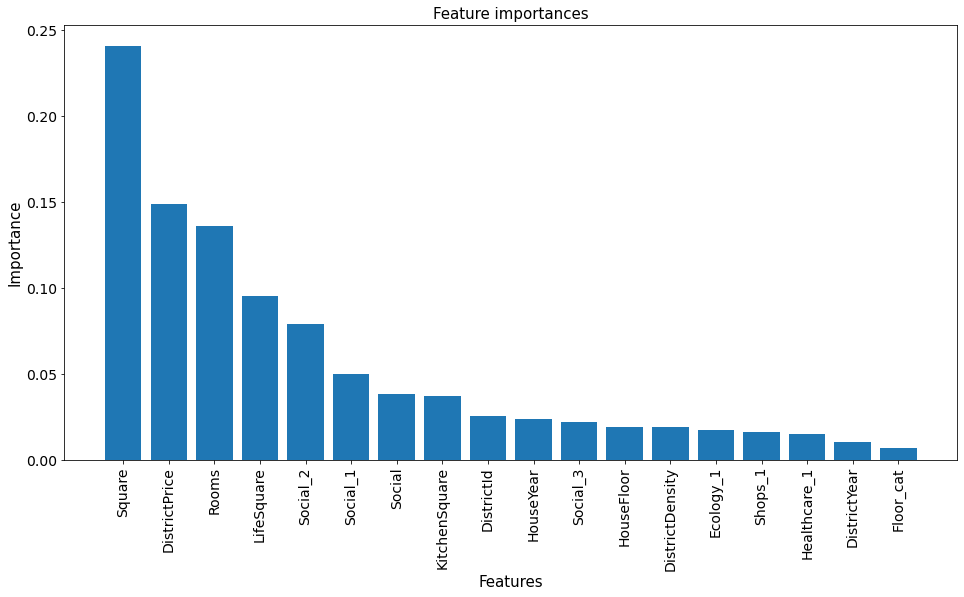

In [82]:
plt.figure(figsize = (16, 8))
plt.bar(feature_importances['feature_name'], feature_importances['importance'])
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Importance', fontsize=15)
plt.title('Feature importances', fontsize=15)
plt.show()

Идея более сложных моделей:

catboost, lightgbm, xgboost

In [83]:
# from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor
# from sklearn.linear_model import LinearRegression

# lr = LinearRegression()
# gb = GradientBoostingRegressor()

# stack = StackingRegressor([('lr', lr), ('rf', rf_model)], final_estimator=gb)
# stack.fit(X_train, y_train)

In [84]:
# y_train_preds = stack.predict(X_train)
# y_test_preds = stack.predict(X_valid)

# evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

### 8. Прогнозирование на тестовом датасете  <a class='anchor' id='prediction'>

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Не потерять и не перемешать индексы от примеров при построении прогнозов
3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [85]:
test_df.shape

(5000, 18)

In [86]:
train_df.shape

(9900, 18)

In [87]:
test_df.isna().all()

DistrictId         False
Rooms              False
Square             False
LifeSquare         False
KitchenSquare      False
HouseFloor         False
HouseYear          False
Ecology_1          False
Social_1           False
Social_2           False
Social_3           False
Healthcare_1       False
Shops_1            False
DistrictYear       False
DistrictDensity    False
DistrictPrice      False
Floor_cat          False
Social             False
dtype: bool

In [88]:
train_df.isna().all()

DistrictId         False
Rooms              False
Square             False
LifeSquare         False
KitchenSquare      False
HouseFloor         False
HouseYear          False
Ecology_1          False
Social_1           False
Social_2           False
Social_3           False
Healthcare_1       False
Shops_1            False
DistrictYear       False
DistrictDensity    False
DistrictPrice      False
Floor_cat          False
Social             False
dtype: bool

In [89]:
submit = pd.read_csv('/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [90]:
# predictions = rf_model.predict(test_df)
# predictions

In [91]:
predictions = gb_model.predict(test_df)
predictions

array([161934.19820366, 129131.77907135, 138634.02206484, ...,
       151246.89110484, 187093.37652939, 270797.38229431])

In [92]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,161934.198204
1,5925,129131.779071
2,960,138634.022065
3,3848,110272.921189
4,746,190720.162393


In [93]:
submit.to_csv('submission.csv', index=False)